In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary  # Denne er fin for å printe ut informasjon om PyTorch-modeller
import matplotlib.pyplot as plt
from collections import Counter
from code_base.functions import train, train_models, select_best_model, evaluate_performance
from code_base.models import TestNet, LeNetVariant
from code_base.DataAnalysis import DataAnalysis
from code_base.object_detection import plot_instances, get_converted_data

In [ ]:
SEED = 265
torch.manual_seed(SEED)

DEVICE = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Using device: {DEVICE}")

Using device: cuda


# Object Localization

## Data exploration

In [ ]:
# Loading the data as PyTorch Tensor Dataset
data_train = torch.load("data/localization_train.pt")
data_val = torch.load("data/localization_val.pt")
data_test = torch.load("data/localization_test.pt")
print("Type: ", type(data_train))

Type:  <class 'torch.utils.data.dataset.TensorDataset'>


In [ ]:
DataAnalysis.get_summary(data_train)

Type of images in dataset: <class 'torch.Tensor'>
First image in dataset: tensor([[[0.3647, 0.2938, 0.2765,  ..., 0.3936, 0.3678, 0.5296],
         [0.2512, 0.2223, 0.3063,  ..., 0.4712, 0.3880, 0.3778],
         [0.2182, 0.1546, 0.3569,  ..., 0.6240, 0.3413, 0.4354],
         ...,
         [0.6697, 0.6960, 0.2436,  ..., 0.3731, 0.5221, 0.4018],
         [0.8009, 0.6783, 0.4918,  ..., 0.5213, 0.3627, 0.2501],
         [0.8217, 0.7294, 0.3937,  ..., 0.6089, 0.1960, 0.3527]]])
First data label (a vector of P_c, box_x_pos, box_y_pos, box_height, box_width, class label):  tensor([1.0000, 0.6000, 0.2292, 0.3667, 0.4167, 4.0000])
Dataset size: 59400
Dataset shape: torch.Size([59400, 1, 48, 60])
Image shape: torch.Size([1, 48, 60])

----- Dataset class distribution (-1 for no object) -----
Class -1: 5400 examples
Class 0: 5345 examples
Class 1: 6075 examples
Class 2: 5365 examples
Class 3: 5522 examples
Class 4: 5243 examples
Class 5: 4889 examples
Class 6: 5310 examples
Class 7: 5644 example

In [ ]:
DataAnalysis.get_summary(data_val)

Type of images in dataset: <class 'torch.Tensor'>
First image in dataset: tensor([[[0.6313, 0.7533, 0.6194,  ..., 0.4337, 0.4831, 0.3022],
         [0.7073, 0.4611, 0.5142,  ..., 0.5610, 0.5517, 0.5982],
         [0.6114, 0.4698, 0.4360,  ..., 0.6417, 0.4758, 0.4271],
         ...,
         [0.4714, 0.5969, 0.3056,  ..., 0.4580, 0.4583, 0.2852],
         [0.6684, 0.4994, 0.5108,  ..., 0.4111, 0.4682, 0.4607],
         [0.5233, 0.5018, 0.3971,  ..., 0.4283, 0.2382, 0.1903]]])
First data label (a vector of P_c, box_x_pos, box_y_pos, box_height, box_width, class label):  tensor([1.0000, 0.6167, 0.6250, 0.3667, 0.4583, 5.0000])
Dataset size: 6600
Dataset shape: torch.Size([6600, 1, 48, 60])
Image shape: torch.Size([1, 48, 60])

----- Dataset class distribution (-1 for no object) -----
Class -1: 600 examples
Class 0: 578 examples
Class 1: 667 examples
Class 2: 593 examples
Class 3: 609 examples
Class 4: 599 examples
Class 5: 532 examples
Class 6: 608 examples
Class 7: 621 examples
Class 8: 

In [ ]:
DataAnalysis.get_summary(data_test)

Type of images in dataset: <class 'torch.Tensor'>
First image in dataset: tensor([[[0.2210, 0.4416, 0.3534,  ..., 0.5535, 0.6887, 0.5598],
         [0.2845, 0.3973, 0.3458,  ..., 0.4800, 0.5693, 0.5542],
         [0.2051, 0.3117, 0.1947,  ..., 0.4572, 0.4547, 0.4019],
         ...,
         [0.2451, 0.3729, 0.2737,  ..., 0.0782, 0.1691, 0.0667],
         [0.3223, 0.3826, 0.3099,  ..., 0.2794, 0.2301, 0.0541],
         [0.2335, 0.4308, 0.3738,  ..., 0.1801, 0.1865, 0.0000]]])
First data label (a vector of P_c, box_x_pos, box_y_pos, box_height, box_width, class label):  tensor([1.0000, 0.4000, 0.2188, 0.2667, 0.2292, 5.0000])
Dataset size: 11000
Dataset shape: torch.Size([11000, 1, 48, 60])
Image shape: torch.Size([1, 48, 60])

----- Dataset class distribution (-1 for no object) -----
Class -1: 1000 examples
Class 0: 980 examples
Class 1: 1135 examples
Class 2: 1032 examples
Class 3: 1010 examples
Class 4: 982 examples
Class 5: 892 examples
Class 6: 958 examples
Class 7: 1028 examples
Cl

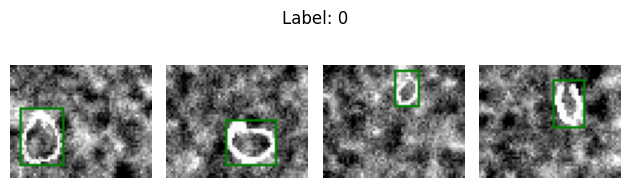

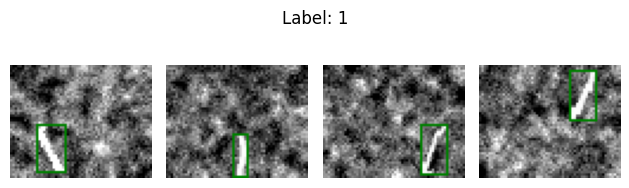

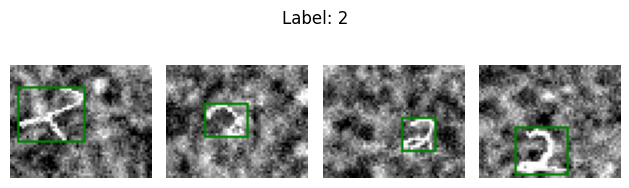

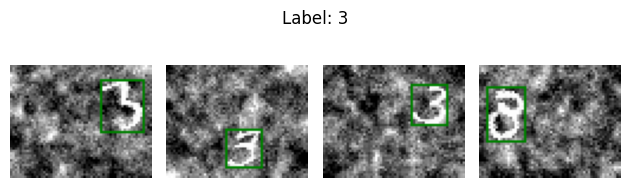

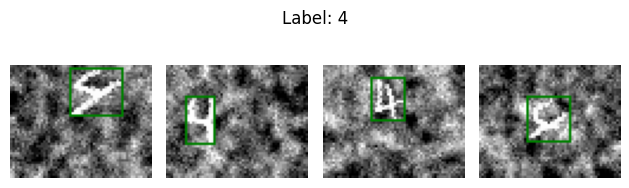

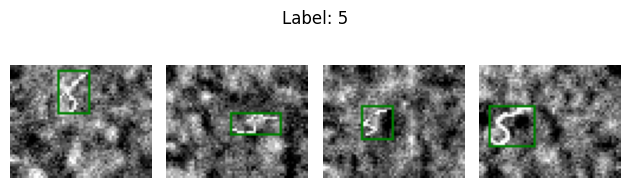

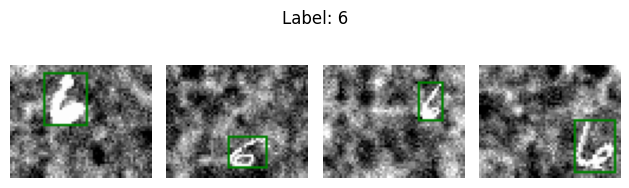

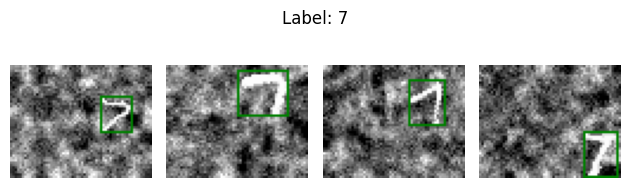

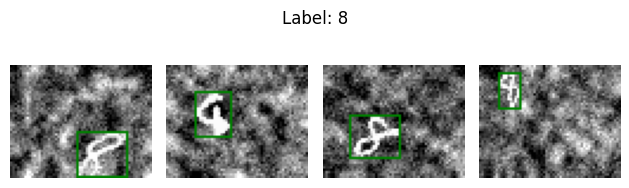

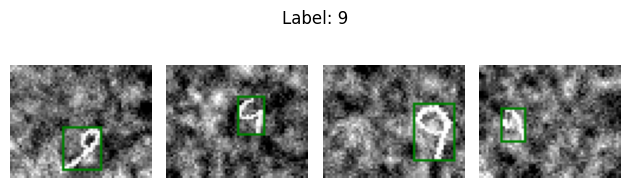

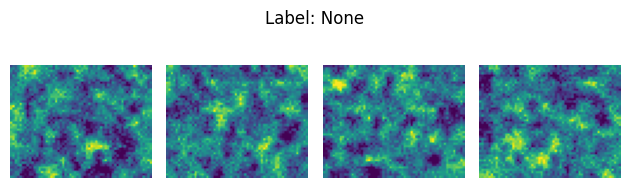

In [ ]:
# Display 4 instances of each class
n_classes = len(Counter([int(label[-1]) for _, label in data_train]))
for i in range(n_classes):
    DataAnalysis.plot_instances_with_bounding_box(data_train, i, n_instances=4)
# No class
DataAnalysis.plot_instances_with_bounding_box(data_train, None, n_instances=4)

## Training

In [ ]:
# Normalize from training data
imgs = torch.stack([img for img, _ in data_train])

# Define normalizer
normalizer = transforms.Normalize(
    imgs.mean(dim=(0, 2, 3)), 
    imgs.std(dim=(0, 2, 3))
    )

data_train_norm = [(normalizer(img), label) for img, label in data_train]
data_val_norm = [(normalizer(img), label) for img, label in data_val]
data_test_norm = [(normalizer(img), label) for img, label in data_test]

In [ ]:
batch_size = 32
train_loader = DataLoader(data_train_norm, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(data_val_norm, batch_size=batch_size, shuffle=False)

In [ ]:
epochs = 5
networks = [TestNet]

hyper_parameters = [
    {"lr": 0.001, "weight_decay": 0.0, "momentum": 0.0},
    # {"lr": 0.01, "weight_decay": 0.01, "momentum": 0.0},
    # {"lr": 0.01, "weight_decay": 0.9, "momentum": 0.0},
]

In [ ]:
trained_models, train_performances, val_performances, train_losses, val_losses = train_models(
    "localization",
    networks,
    hyper_parameters,
    batch_size,
    epochs,
    train_loader,
    val_loader,
    DEVICE,
    SEED)

	Global parameters:
Batch size: 32
Epochs: 5
Seed: 265

Model architecture: <class 'code_base.models.TestNet'>

	Current parameters: 
lr:0.001
weight_decay:0.0
momentum:0.0
Starting training for localization using above parameters:

12:31:21.735692
Epoch: 1
train_loss:              2.619
val_loss:                2.507
train_performance:       0.247%
val_performance:         0.091%

12:38:10.041538
Epoch: 5
train_loss:              2.463
val_loss:                2.457
train_performance:       0.221%
val_performance:         0.303%


 --- Performance ---
Training performance: 0.22%
Validation performance: 0.30%


In [ ]:
best_model, best_model_idx = select_best_model(trained_models, val_performances)
print(best_model)

TestNet


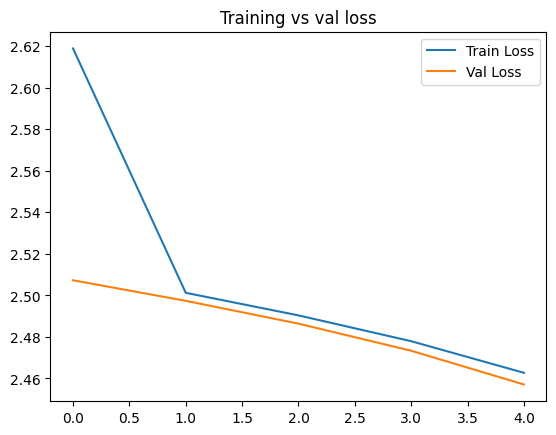

In [ ]:
best_model_train_loss = train_losses[best_model_idx]
best_model_val_loss = val_losses[best_model_idx]
best_model_train_performance = train_performances[best_model_idx]
best_model_val_performance = val_performances[best_model_idx]
DataAnalysis.plot_performance_over_time(best_model_train_loss, best_model_val_loss, "Training vs val loss")

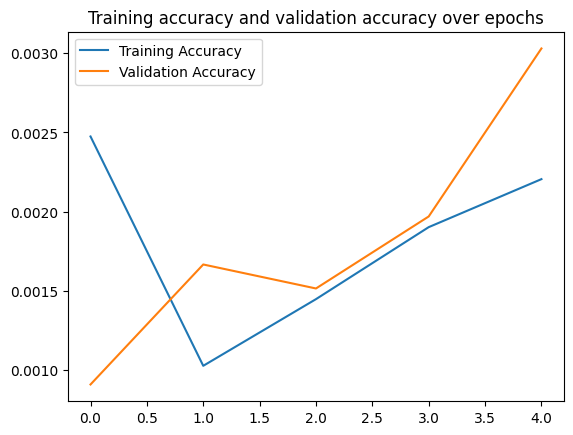

In [ ]:
DataAnalysis.plot_performance_over_time(best_model_train_performance, best_model_val_performance, "Training accuracy and validation accuracy over epochs", 
                               label1="Training Accuracy", label2="Validation Accuracy")

## Evaluation

In [ ]:
test_loader = DataLoader(data_test_norm, batch_size=batch_size, shuffle=False)

perf, output = evaluate_performance(best_model, test_loader, DEVICE)
print(f"Test performance: {perf*100:.2f}%")

TypeError: evaluate_performance() missing 1 required positional argument: 'device'

In [ ]:
for i in range(10):
    DataAnalysis.plot_instances_with_bounding_box(data_test, i, predictions=output)
DataAnalysis.plot_instances_with_bounding_box(data_test, None, predictions=output)

# Object Detection

## Data exploration

In [ ]:
grid_dimensions = (2,3)

In [ ]:
object_train, _, _ = get_converted_data(grid_dimensions=grid_dimensions) 

In [ ]:
plot_instances(object_train, 4, grid_dimensions=grid_dimensions)

In [ ]:
print(object_train[0][1].shape)